# Feature engineering for XGBoost

## 1. Convert ds Column to Datetime

In [1]:
# 1. convert ds column into datetime

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("D:/Credit_Card_Spend_Analysis/data/processed_data.csv")

df['ds'] = pd.to_datetime(df['ds'])



## 2. Check for Missing or Duplicate Timestamps
#### Missing timestamps can create gaps in the time series.<br>
#### Duplicates can indicate multiple events for the same time.

In [2]:
#check for missing timestamps
missing_timestamps = df['ds'].isnull().sum()
print(f"Missing timestamps: {missing_timestamps}")

duplicate_timestamps = df['ds'].duplicated().sum()
print(f"Duplicated timestamps : {duplicate_timestamps}")

Missing timestamps: 0
Duplicated timestamps : 20821


## 3. Check Time Frequency & Regularity
#### Time series should have a consistent frequency (daily, hourly, etc.).
#### Detect irregularities or missing periods.

In [3]:
print(df['ds'].diff().value_counts().head(10))

ds
0 days 00:00:01    40640
0 days 00:00:02    38934
0 days 00:00:03    37314
0 days 00:00:04    36549
0 days 00:00:05    34638
0 days 00:00:06    33144
0 days 00:00:07    32264
0 days 00:00:08    30630
0 days 00:00:09    29726
0 days 00:00:10    28462
Name: count, dtype: int64


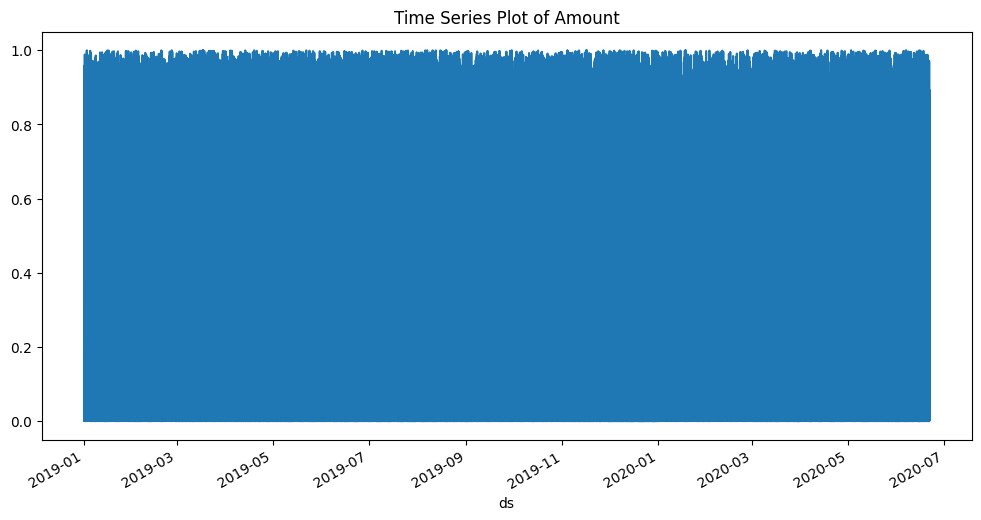

In [4]:
#to visualize 
df.set_index('ds')['amt'].plot(figsize=(12, 6), title='Time Series Plot of Amount')
plt.show()

## 4. Complexity Analysis (Trend, Seasonality, Noise)
#### To analyze time series complexity, you can:

#### a) Decompose into Trend, Seasonality, and Residuals
### Using statsmodels to decompose:

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(df.set_index('ds')['amt'], model='additive', period=7)
result.plot()
plt.show()

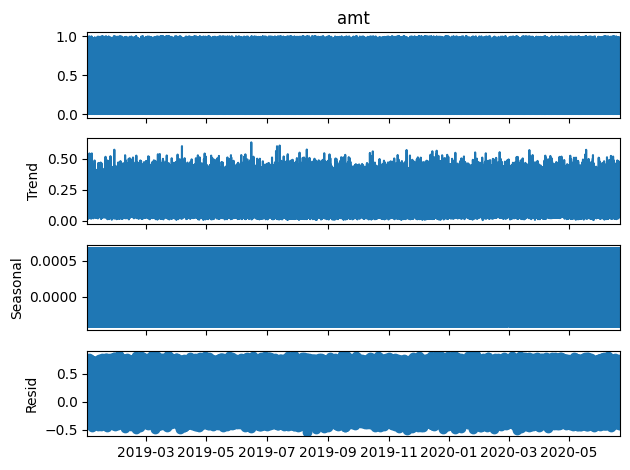

* Trend: Long-term pattern in data.
* Seasonality: Repeating cycles.
* Residuals: Noise or random fluctuations.


#### b) Check for Seasonality Using Autocorrelation

In [ ]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df['amt'])
plt.show()

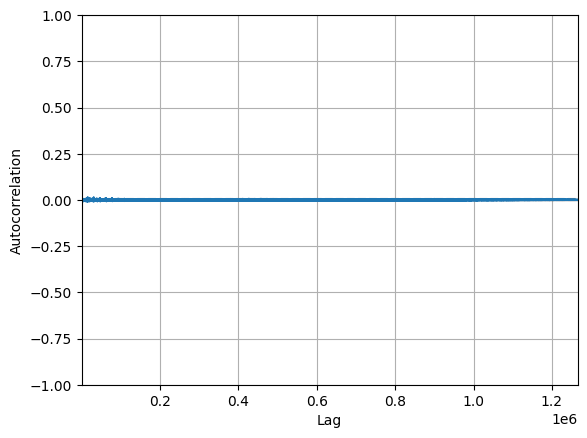

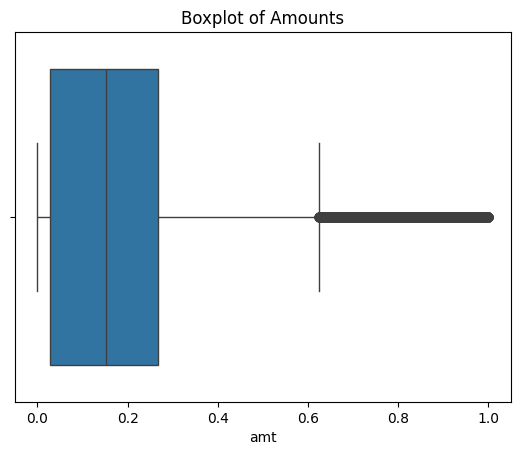

In [7]:
import seaborn as sns

sns.boxplot(x=df['amt'])
plt.title("Boxplot of Amounts")
plt.show()


In [8]:
df['hour'] = df['ds'].dt.hour
df['minute'] = df['ds'].dt.minute
df['second'] = df['ds'].dt.second
df['day_of_week'] = df['ds'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)
df['month'] = df['ds'].dt.month
df['quarter'] = df['ds'].dt.quarter
df['week_of_year'] = df['ds'].dt.isocalendar().week
df['year'] = df['ds'].dt.year


In [9]:
df = df.groupby('ds').mean().reset_index()


In [ ]:
df['lag_1'] = df['amt'].shift(1)
df['lag_7'] = df['amt'].shift(7)  # Weekly trend
df['lag_30'] = df['amt'].shift(30)  # Monthly trend


In [11]:
df['rolling_mean_7'] = df['amt'].rolling(7).mean()
df['rolling_std_7'] = df['amt'].rolling(7).std()


[0]	validation_0-rmse:0.17573
[1]	validation_0-rmse:0.17431
[2]	validation_0-rmse:0.17369
[3]	validation_0-rmse:0.17253
[4]	validation_0-rmse:0.17138
[5]	validation_0-rmse:0.17034
[6]	validation_0-rmse:0.16945
[7]	validation_0-rmse:0.16858
[8]	validation_0-rmse:0.16778
[9]	validation_0-rmse:0.16739
[10]	validation_0-rmse:0.16726
[11]	validation_0-rmse:0.16658
[12]	validation_0-rmse:0.16595
[13]	validation_0-rmse:0.16544
[14]	validation_0-rmse:0.16491
[15]	validation_0-rmse:0.16470
[16]	validation_0-rmse:0.16424
[17]	validation_0-rmse:0.16403
[18]	validation_0-rmse:0.16384
[19]	validation_0-rmse:0.16346
[20]	validation_0-rmse:0.16311
[21]	validation_0-rmse:0.16279
[22]	validation_0-rmse:0.16249
[23]	validation_0-rmse:0.16223
[24]	validation_0-rmse:0.16198
[25]	validation_0-rmse:0.16176
[26]	validation_0-rmse:0.16156
[27]	validation_0-rmse:0.16140
[28]	validation_0-rmse:0.16125
[29]	validation_0-rmse:0.16120
[30]	validation_0-rmse:0.16105
[31]	validation_0-rmse:0.16091
[32]	validation_0-

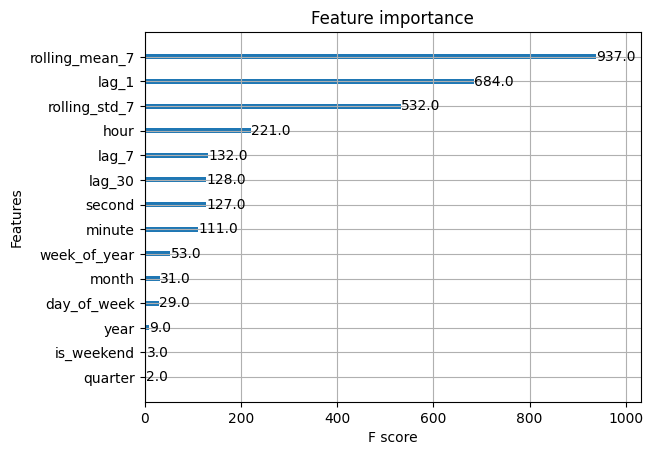

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

features = ['hour', 'minute', 'second', 'day_of_week', 'is_weekend', 'month', 
            'quarter', 'week_of_year', 'year', 'lag_1', 'lag_7', 'lag_30', 
            'rolling_mean_7', 'rolling_std_7']

X = df[features]
y = df['amt']
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, cross_val_score
import numpy as np

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Define XGBoost model with regularization and early stopping
model = XGBRegressor(
    n_estimators=200,        # Reduce trees
    max_depth=4,             # Shallower trees
    learning_rate=0.05,      # Lower learning rate
    reg_lambda=2,            # L2 regularization
    reg_alpha=1,             # L1 regularization
    subsample=0.8,           # Randomly sample 80% of data per tree
    colsample_bytree=0.8,    # Use 80% of features per tree
    random_state=42
)

# Train the model with early stopping
model.fit(X_train, y_train, eval_set=[(X_val, y_val)],
           verbose=True)

# Cross-validation
scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
print("Cross-validated MSE:", np.abs(scores.mean()))

# Feature Importance Plot
import matplotlib.pyplot as plt
from xgboost import plot_importance

plot_importance(model)
plt.show()



In [36]:

# Predict on validation set
y_pred = model.predict(X_val)

# Calculate Mean Squared Error (MSE) or Root Mean Squared Error (RMSE)
mse = mean_squared_error(y_val, y_pred)
rmse = np.sqrt(mse)

print(f"Validation MSE: {mse}")
print(f"Validation RMSE: {rmse}")


Validation MSE: 0.025366720385880823
Validation RMSE: 0.15926933284810615


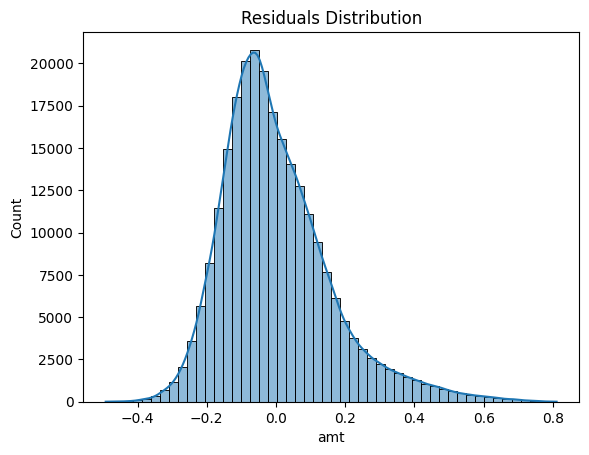

In [37]:
import seaborn as sns

residuals = y_val - y_pred
sns.histplot(residuals, bins=50, kde=True)
plt.title("Residuals Distribution")
plt.show()


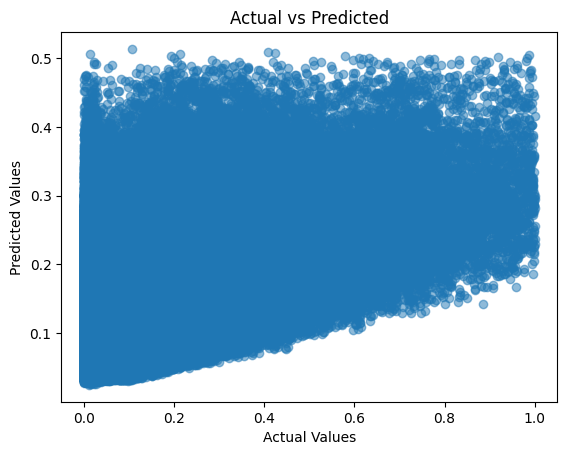

In [38]:
plt.scatter(y_val, y_pred, alpha=0.5)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted")
plt.show()


In [39]:
sample = X_val.iloc[[0]]  # Take one row from validation set
pred = model.predict(sample)
print(f"Predicted amount: {pred[0]}")
print(f"Actual amount: {y_val.iloc[0]}")


Predicted amount: 0.21166296303272247
Actual amount: 0.196294662549625
